<a href="https://colab.research.google.com/github/Guna614/AI-ML-Task-Voice-Based-Cognitive-Decline-Pattern-Detection/blob/main/Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***AI/ML Task: Voice-Based Cognitive Decline Pattern Detection***

1. Install Required Packages

In [ ]:
!pip install librosa pydub SpeechRecognition webrtcvad
!pip install nltk spacy scikit-learn matplotlib seaborn pandas numpy
!python -m nltk.downloader all
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 29.6 MB/s eta 0:00:00
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp311-cp311-linux_x86_64.whl size=73496 sha256=202afaefad022d45ccda952870036afd2195fdc94fe186ac09aed0c3ca33bd30
  Stored in directory: /root/.cache/pip/wheels/94/65/3f/292d0b656be33d1c801831201c74b5f68f41a2ae465ff2ee2f
Successfully built webrtcvad
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | 

 2. Import Libraries and Setup

In [ ]:
import librosa
import librosa.display
import speech_recognition as sr
from pydub import AudioSegment
import webrtcvad
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
# Load NLP models
nlp = spacy.load("en_core_web_sm")
nltk.download("punkt")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**3. Upload & List Audio Files**

In [ ]:
from google.colab import files
uploaded = files.upload()
os.makedirs("voice_clips", exist_ok=True)
for filename in uploaded:
    os.rename(filename, f"voice_clips/{filename}")
AUDIO_DIR = "voice_clips"
audio_files = [f for f in os.listdir(AUDIO_DIR) if f.endswith('.wav')]
print("Uploaded files:", audio_files)


Saving 14 Apr, 3.35 pm_.wav to 14 Apr, 3.35 pm_.wav
Saving 14 Apr, 3.36 pm_.wav to 14 Apr, 3.36 pm_.wav
Saving 14 Apr, 3.14 pm_(2).wav to 14 Apr, 3.14 pm_(2).wav
Saving 14 Apr, 3.14 pm_.wav to 14 Apr, 3.14 pm_.wav
Saving harvard.wav to harvard.wav
Saving self-destruction-sequence-initiated-robotic-female-tomas-herudek-1-00-05.wav to self-destruction-sequence-initiated-robotic-female-tomas-herudek-1-00-05.wav
Saving i-will-have-my-revenge-robot-male-epic-stock-media-1-00-03.wav to i-will-have-my-revenge-robot-male-epic-stock-media-1-00-03.wav
Saving oh-my-god-female-gfx-sounds-1-1-00-01.wav to oh-my-god-female-gfx-sounds-1-1-00-01.wav
Saving sample-pack-links-in-bio-sampled-stuff-288267.wav to sample-pack-links-in-bio-sampled-stuff-288267.wav
Saving hol-up-voice-one-shot-77742.wav to hol-up-voice-one-shot-77742.wav
Saving 086299_pinkie-pie-have-a-cupcakewav-86111.wav to 086299_pinkie-pie-have-a-cupcakewav-86111.wav
Saving catgirl-saying-quotwhisker-a-secret-in-my-ear-nyaquot-230765.wav 

**`** 4. Transcribe Audio to Text**`**

In [ ]:
recognizer = sr.Recognizer()

def transcribe_audio(file_path):
    with sr.AudioFile(file_path) as source:
        audio = recognizer.record(source)
        try:
            return recognizer.recognize_google(audio)
        except sr.UnknownValueError:
            return ""
        except sr.RequestError:
            return ""

transcriptions = {}
for f in audio_files:
    path = os.path.join(AUDIO_DIR, f)
    transcriptions[f] = transcribe_audio(path)
for fname, text in transcriptions.items():
    print(f"\n{fname}: {text}")



14 Apr, 3.35 pm_.wav: good morning everyone today I want to talk briefly about our CL

086299_pinkie-pie-have-a-cupcakewav-86111.wav: 

self-destruction-sequence-initiated-robotic-female-tomas-herudek-1-00-05.wav: self destruction sequence initiated

sample-pack-links-in-bio-sampled-stuff-288267.wav: today's sound is designed to suit you entertainment

kendrick-lamar-spoken-vocal-thug-in-the-trenches_75bpm_F.wav: I'm a thug in the trenches fighting every damn day started from the bottom now I'm making me niggas call me crazy but I'm just insane Spitfire in the booth got him feeling the pain

14 Apr, 3.14 pm_.wav: yeah then I walked over the cereal but forgot why I was there in the first place

adam-neely-spoken-vocals_109bpm.wav: I get it but there's a fundamental difference there and it relates to me personally and how I want to express myself it's not so much that

oh-my-god-female-gfx-sounds-1-1-00-01.wav: oh my God

14 Apr, 3.14 pm_(2).wav: it's happening more often lately and I d

**5. Extract Audio & NLP Features**

In [ ]:
import re
import librosa
import numpy as np
import speech_recognition as sr
def extract_audio_features(file_path, text):
    y, sr = librosa.load(file_path)
    duration = librosa.get_duration(y=y, sr=sr)
    speech_rate = len(text.split()) / duration if duration > 0 else 0
    pitch = librosa.yin(y, fmin=50, fmax=300)
    pitch_var = np.std(pitch)
    hesitation_words = ['um', 'uh', 'erm', 'ah', 'like', 'you know', 'so']
    hesitations = sum(len(re.findall(r'\b' + hw + r'\b', text.lower())) for hw in hesitation_words)
    pauses = sum(1 for word in text.split() if word in ['.', ',', '?', '!', '...', '—'])
    return {
        'speech_rate': speech_rate,
        'pitch_var': pitch_var,
        'hesitations': hesitations,
        'pauses': pauses,
        'word_count': len(text.split())
    }
feature_data = []
for f in audio_files:
    path = os.path.join(AUDIO_DIR, f)
    text = transcriptions[f]
    features = extract_audio_features(path, text)
    features['file'] = f
    feature_data.append(features)
df_features = pd.DataFrame(feature_data)
df_features.set_index('file', inplace=True)
df_features


,speech_rate,pitch_var,hesitations,pauses,word_count
file,,,,,
"14 Apr, 3.35 pm_.wav",0.815217,46.933247,0,0,12
086299_pinkie-pie-have-a-cupcakewav-86111.wav,0.000000,82.052439,0,0,0
self-destruction-sequence-initiated-robotic-female-tomas-herudek-1-00-05.wav,0.756569,86.640789,0,0,4
sample-pack-links-in-bio-sampled-stuff-288267.wav,1.750000,70.804714,0,0,8
kendrick-lamar-spoken-vocal-thug-in-the-trenches_75bpm_F.wav,2.251838,33.264526,0,0,35
"14 Apr, 3.14 pm_.wav",1.435811,43.029278,0,0,17
adam-neely-spoken-vocals_109bpm.wav,2.866242,91.674580,1,0,27
oh-my-god-female-gfx-sounds-1-1-00-01.wav,2.509770,78.175754,0,0,3
"14 Apr, 3.14 pm_(2).wav",1.165254,40.981414,0,0,11


**6. Anomaly Detection using Isolation Forest**

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)
model = IsolationForest(contamination=0.2, random_state=42)
df_features['anomaly_score'] = model.fit_predict(X_scaled)  # This adds the 'anomaly_score' column
df_features['risk'] = df_features['anomaly_score'].apply(lambda x: 'At Risk' if x == -1 else 'Normal')
df_features


,speech_rate,pitch_var,hesitations,pauses,word_count,anomaly_score,risk
file,,,,,,,
"14 Apr, 3.35 pm_.wav",0.815217,46.933247,0,0,12,1,Normal
086299_pinkie-pie-have-a-cupcakewav-86111.wav,0.000000,82.052439,0,0,0,1,Normal
self-destruction-sequence-initiated-robotic-female-tomas-herudek-1-00-05.wav,0.756569,86.640789,0,0,4,1,Normal
sample-pack-links-in-bio-sampled-stuff-288267.wav,1.750000,70.804714,0,0,8,1,Normal
kendrick-lamar-spoken-vocal-thug-in-the-trenches_75bpm_F.wav,2.251838,33.264526,0,0,35,-1,At Risk
"14 Apr, 3.14 pm_.wav",1.435811,43.029278,0,0,17,1,Normal
adam-neely-spoken-vocals_109bpm.wav,2.866242,91.674580,1,0,27,-1,At Risk
oh-my-god-female-gfx-sounds-1-1-00-01.wav,2.509770,78.175754,0,0,3,1,Normal
"14 Apr, 3.14 pm_(2).wav",1.165254,40.981414,0,0,11,1,Normal


**7. Visualization**

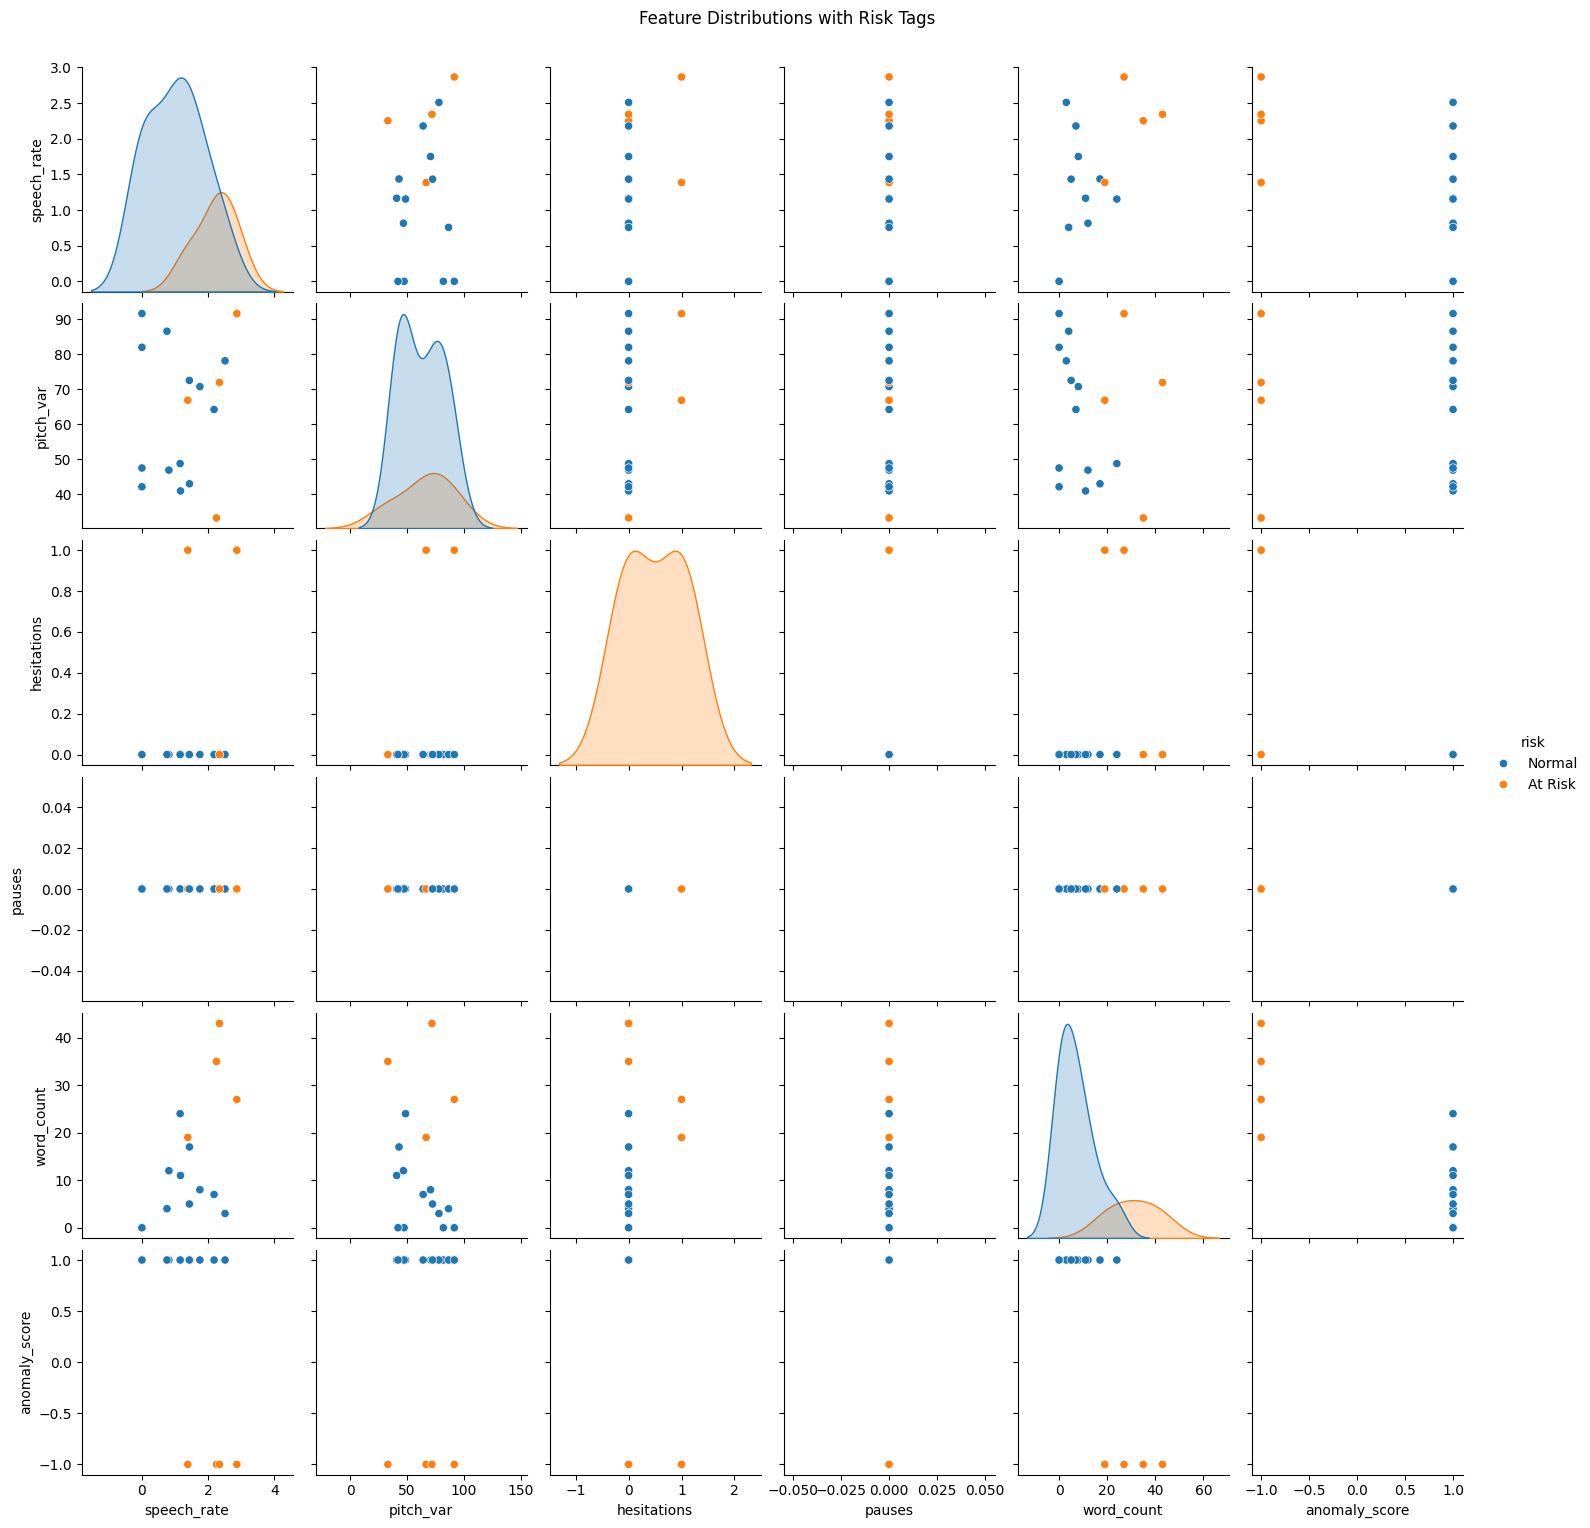

In [7]:
sns.pairplot(df_features, hue='risk')
plt.suptitle("Feature Distributions with Risk Tags", y=1.02)
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

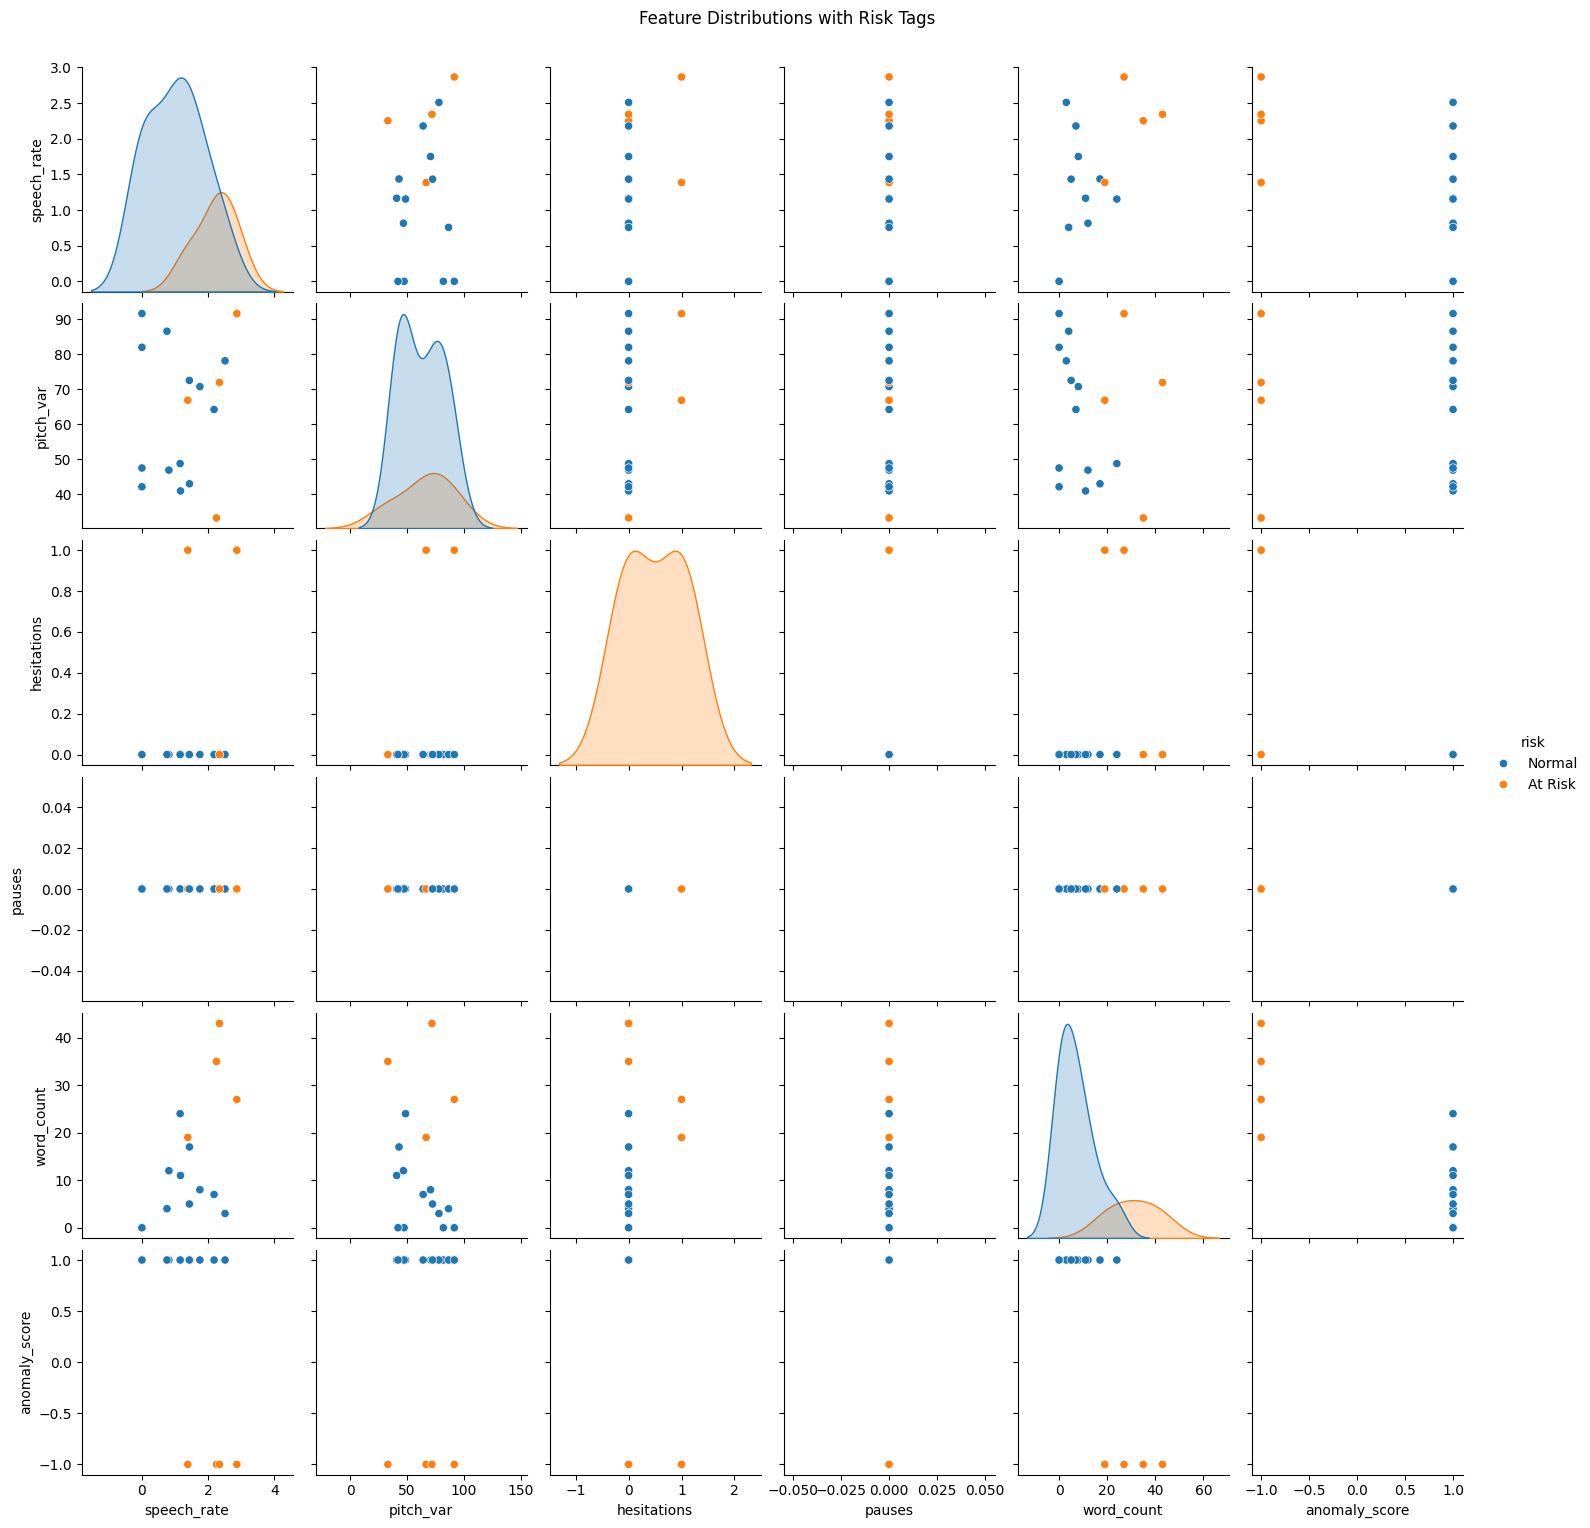

In [ ]:
plot = sns.pairplot(df_features, hue='risk')
plot.fig.suptitle("Feature Distributions with Risk Tags", y=1.02)
plot.savefig("cognitive_risk_plot.png")
from google.colab import files
files.download("cognitive_risk_plot.png")


In [8]:
print(df_features.columns)


Index(['speech_rate', 'pitch_var', 'hesitations', 'pauses', 'word_count',
       'anomaly_score', 'risk'],
      dtype='object')


**8. Optional: Risk Score Function**

In [ ]:
def get_cognitive_score(audio_path):
    text = transcribe_audio(audio_path)
    features = extract_audio_features(audio_path, text)
    input_df = pd.DataFrame([features])
    input_scaled = scaler.transform(input_df)
    risk = model.predict(input_scaled)
    return "At Risk" if risk[0] == -1 else "Normal"
    print(get_cognitive_score("voice_clips/sample1.wav"))